## Sentiment Analysis of r/NBA Posts Using BERT

This notebook performs **sentiment analysis** on Reddit post components — specifically the **title**, **selftext**, and **comments** — using the `cardiffnlp/twitter-roberta-base-sentiment` model from Hugging Face.

### Key Steps:

* Extract and clean text data from Reddit posts
* Apply a BERT-based sentiment model to each part:

  * `Title`: the post’s headline
  * `Selftext`: the post’s body text
  * `Comments`: all user replies concatenated per post
* Analyze the sentiment of each component individually (Positive, Neutral, Negative)
* Handle edge cases (e.g. empty texts or inference errors)
* Optional: visualize or summarize sentiment distributions

This pipeline enables fine-grained analysis of how different parts of Reddit posts vary in sentiment, supporting downstream tasks like user behavior modeling, topic tracking, or content moderation.

In [1]:
import praw
import pandas as pd
from urllib.parse import urlparse
from datetime import datetime

reddit = praw.Reddit(
    client_id= '2ST5tRddm-CMj_VlM-5qGw',
    client_secret= 'PmlPHXvIq7lkSyXhckZ_2bg1lA9-7Q',
    user_agent='MyRedditApp/1.0'
)

def get_subreddit(name):
    subreddit = reddit.subreddit(name)
    #gets the info of the subreddit
    subreddit_info = {
        'name': name,
        'subscribers': subreddit.subscribers,
        'created_utc': datetime.utcfromtimestamp(subreddit.created_utc),
        'display_name': subreddit.display_name,
        'title': subreddit.title,
        'public_description': subreddit.public_description,
    }
    
    return subreddit_info

def get_post_data(name, limit=20):
    subreddit = reddit.subreddit(name)
    posts = []
    
    # Get posts
    for post in subreddit.hot(limit=limit):
        post_data = {
            'title': post.title,
            'score': post.score, 
            'Number of Comments': post.num_comments,
            'selftext': post.selftext,
            'Comments': []
        }
        # Gets comments under the post
        post.comments.replace_more(limit=10)
        for comment in post.comments.list():
            comment_data = {
                'body': comment.body,
                'score': comment.score
            }
            post_data['Comments'].append(comment_data)
                
        posts.append(post_data) 
    
    return posts

In [ ]:
posts = get_post_data('nba', limit=100)
posts

[{'title': 'Weekly Friday Self-Promotion and Fan Art Thread',
  'score': 28,
  'Number of Comments': 6,
  'selftext': "The **Self-Promotion Friday and Fan Art Thread** serves as a place for content creators to share their work with the community at [r/nba](https://old.reddit.com/r/nba). If you'd like to post your work below, there are some guidelines we kindly ask you to follow:\n\n* No linking out to re-sellers/retailers and/or directly selling merchandise via any e-commerce/marketplace type of website (i.e. Etsy, Society 6, Fiverr, etc...). Any websites or blogs explicitly asking users for donations or monetary compensation via any sort of online or mobile payment services are prohibited.\n* No linking out to content behind paywalls or content requiring users to register/create an account in order access said content.\n* Content *must* be relevant to the NBA or r/nba. Comments with content not relevant to the aforementioned will be removed.\n* Be an active member of our community out

In [52]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def cleanTEXT(text):
    text = re.sub(f"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z ]", "", text)
    tokens = text.lower().split()
    return " ".join(tokens)

<>:9: SyntaxWarning: invalid escape sequence '\S'
<>:9: SyntaxWarning: invalid escape sequence '\S'
/var/folders/nw/9w4r5hrd05s122kt5hg_t8bw0000gn/T/ipykernel_62094/2434109999.py:9: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub(f"http\S+", "", text)
[nltk_data] Downloading package stopwords to /Users/alexg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [53]:
titles = []
selftexts = []
all_comments = []

for post in posts:
    title = post['title']
    selftext = post['selftext']
    comments = ",".join([comment['body'] for comment in post['Comments']])
    titles.append(title)
    selftexts.append(selftext)
    all_comments.append(comments)


title_tokens = []
selftext_tokens = []
comment_tokens = []

for text in titles:
    title_tokens.append(cleanTEXT(text))

for selftext in selftexts:
    selftext_tokens.append(cleanTEXT(selftext))

for comment in all_comments:
    comment_tokens.append(cleanTEXT(comment))

comment_tokens
    


['hey guys hope you are doing all welli am a student from a german school and will graduate soon for that i have to write a scientific paper about the nba draft and its influences on the competitive landscape of the league in this paper i also have to use a personal contribution in form of a surveyit would be very helpful if as many people as possible participate in the survey it only takes minutes and all answers will be anonymous and used for academic purpose only so go ahead and take part this is the link for the survey thanks to everyone who participateshave a nice dayself promotion you say in that case i want everyone to know im a pretty ok guytldr top basketballnba tiktoks here hey everyoneive made a leaderboard of the top basketball and nbarelated tiktok videos of all time although you can also filter by country and time periods eg this year i made this because its kind of hard to figure this out directly on tiktok and have the ability to filter nicely would be really interested

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

# Use a fine-tuned sentiment model
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
from transformers import pipeline

# sentiment_pipeline = pipeline(
#     "sentiment-analysis",
#     model=model,
#     tokenizer=tokenizer,
#     device=0,           # 0 = use GPU, -1 = CPU
#     batch_size=32       # You can go higher depending on text length
# )



In [54]:
label_map = {
    'LABEL_0': 'Negative',
    'LABEL_1': 'Neutral',
    'LABEL_2': 'Positive'
}

results = []
for text in comment_tokens:
    try:
        output = sentiment_pipeline(text[:512])[0]
        mapped_output = {
        'text': text[:512],
        'label': label_map.get(output['label'], output['label']),
        'score': output['score']
    }
        results.append(mapped_output)  
    except Exception as e:
        results.append({'label': 'error', 'score': 0, 'error': str(e)})


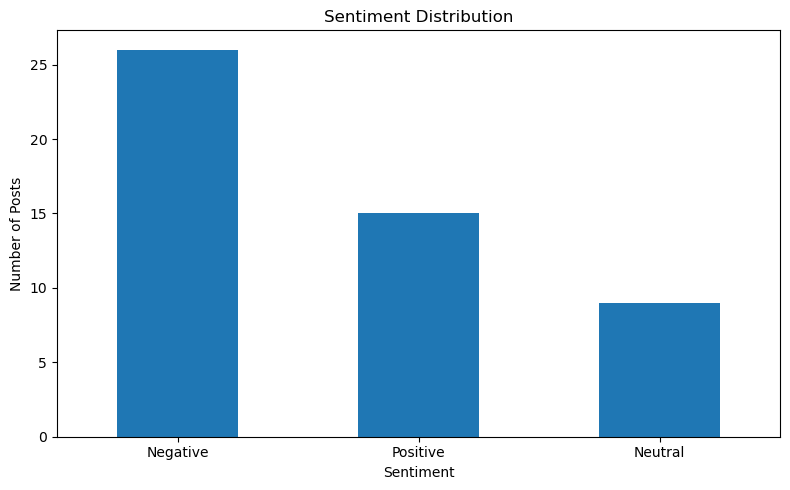

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

res = pd.DataFrame(results)
label_counts = res['label'].value_counts()

# Plot
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
Are Reddit post titles more positive than comments?

Do high-sentiment posts generate more comments?

Is sentiment linked to specific keywords or time periods?